# **SEQUENTIAL**

**Check the GPU**

In [1]:
!nvidia-smi

Wed May 15 11:06:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**Import Libraries**

In [4]:
pip install imgaug

^C
Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   ------- -------------------------------- 184.3/948.0 kB 3.7 MB/s eta 0:00:01
   --------------- ------------------------ 368.6/948.0 kB 3.9 MB/s eta 0:00:01
   ------------------------- -------------- 593.9/948.0 kB 4.2 MB/s eta 0:00:01
   ------------------------------ --------- 727.0/948.0 kB 4.2 MB/s eta 0:00:01
   -------------------------------------- - 921.6/948.0 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 948.0/948.0 kB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
    --------------------------------------- 0.2/12.7 MB 4.8 MB/s eta 0:00:03
   - -------------------------------------- 0.4/12.7 MB 4.2 MB/s eta 0:00:03
   - -------------------------------------- 0.5/12.7 MB 4.4 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/12.7 MB 3.7 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/12.7 MB 3.5 MB/s eta 0:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
import csv
import random
#For Splitting the dataset into train test
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#For building the CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

#For augmenting the dataset
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

ModuleNotFoundError: No module named 'imgaug'

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Setting the Random Seed**

In [5]:
# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible
np.random.seed(42)
tf.random.set_seed(42)

**Downloading the Dataset from Kaggle**

In [6]:
!pip install kaggle
!kaggle datasets download -d jangedoo/utkface-new
!unzip -q utkface-new.zip

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:15<00:00, 23.6MB/s]
100% 331M/331M [00:15<00:00, 22.2MB/s]


**Removing Unnecessary Folders from the Dataset**

In [7]:
!rm -rf crop_part1
!rm -rf utkface_aligned_cropped

**Augmenting the dataset with 9 augmented copies of each image**

In [9]:
# Define the augmentation sequence.
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Vertical mirroring
    iaa.Affine(rotate=(-15, 15)),  # Random rotation between -15 and 15 degrees
    iaa.Resize((64, 64))  # Resize to 64x64
])

# Create a directory for the augmented images.
!mkdir UTKFace_augmented

files = os.listdir('UTKFace')
# Iterate through the files in the UTKFace folder.
for file in files:
    # Load the image.
    image = imageio.imread(os.path.join('UTKFace', file))

    # Generate 10 augmented versions of the image.
    images_aug = seq.augment_images([image] * 10)

    # Save the augmented images to the new directory.
    for i, image_aug in enumerate(images_aug):
        imageio.imwrite(os.path.join('UTKFace_augmented', f'{file.split(".")[0]}_{i}.jpg'), image_aug)


mkdir: cannot create directory ‘UTKFace_augmented’: File exists


<ipython-input-9-2eb31c5b2468>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join('UTKFace', file))


**Creating a csv file with filenames and respective age**

In [12]:

# Create a list of all files in the UTKFace folder.
files = os.listdir('UTKFace_augmented')

# Create a CSV file and write the header row.
with open('UTKFace_augmented.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'age'])

    # Iterate through the files in the UTKFace folder.
    for file in files:
        # Extract the age from the filename.
        age = int(file.split('_')[0])

        # Create the full filename.
        filename = os.path.join('UTKFace_augmented', file)

        # Write the image address and age to the CSV file.
        writer.writerow([filename, age])


**Verify the number of datapoints**

In [13]:
# Get the list of files in the UTKFace_aug folder.
files_in_UTKFace = os.listdir('UTKFace')
files_in_UTKFace_augmented = os.listdir('UTKFace_augmented')

# Print the number of files.
print(f'Number of files in UTKFace_augmented folder: {len(files_in_UTKFace)}')
print(f'Number of files in UTKFace_augmented folder: {len(files_in_UTKFace_augmented)}')


Number of files in UTKFace_augmented folder: 23708
Number of files in UTKFace_augmented folder: 237080


**Splitting data into train**

In [14]:
# prompt: divide the df in two dataframes in a 80:20 ratio
df = pd.read_csv('UTKFace_augmented.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


**Plotting the class frequency**

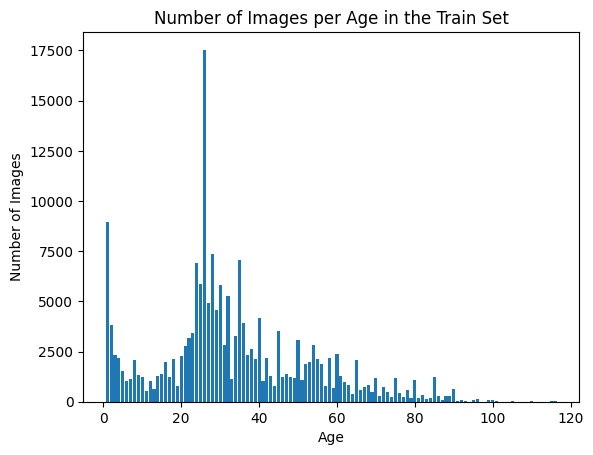

In [44]:
# prompt: i wana plot a bar graph to see how many images belong to what age

# Extract the age column from the DataFrame.
ages = df_train['age']

# Count the number of images for each age.
age_counts = ages.value_counts()

# Create a bar plot of the age counts.
plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.title('Number of Images per Age in the Train Set')
plt.show()


<ipython-input-49-bb5f34f52010>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename)


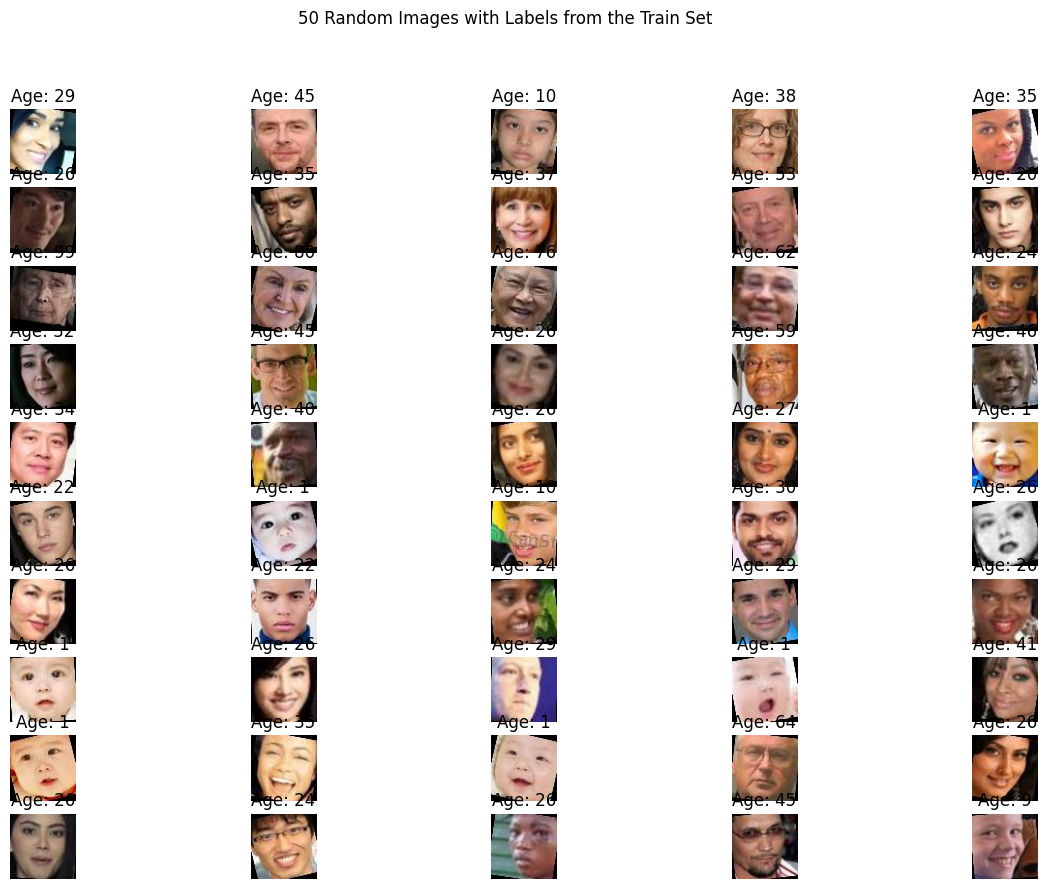

In [49]:
# prompt: display 50 random images with labels in a 10 x 5 grid

# Get the list of filenames and ages from the train DataFrame.
filenames = df_train['filename'].tolist()
ages = df_train['age'].tolist()

# Shuffle the data.
combined = list(zip(filenames, ages))
random.shuffle(combined)
filenames, ages = zip(*combined)

# Display 50 random images with labels in a 10 x 5 grid.
fig, axs = plt.subplots(10, 5, figsize=(15, 10))
for i, (filename, age) in enumerate(zip(filenames[:50], ages[:50])):
    ax = axs[i // 5, i % 5]
    img = imageio.imread(filename)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Age: {age}')
    ax.axis('off')

plt.suptitle('50 Random Images with Labels from the Train Set')
plt.show()


**Mapping the class labels from >100 ages to 8 age groups**

In [15]:
# Defining a function to return the class labels corresponding to the re-distributed 8 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 25:
        return 3
    elif 26 <= age <= 35:
        return 4
    elif 36 <= age <= 45:
        return 5
    elif 46 <= age <= 65:
        return 6
    else:
        return 7

In [16]:
df_train['target'] = df_train['age'].map(class_labels_reassign)
df_test['target'] = df_test['age'].map(class_labels_reassign)

df_train.head()

,filename,age,target
116023,UTKFace_augmented/80_1_0_20170110181333958_3.jpg,80,7
148927,UTKFace_augmented/26_0_1_20170116005302166_4.jpg,26,4
133490,UTKFace_augmented/27_0_4_20170117120226377_6.jpg,27,4
76079,UTKFace_augmented/8_0_3_20170104225706490_4.jpg,8,1
135291,UTKFace_augmented/1_1_0_20170109190724839_6.jpg,1,0


**Defining X and Y Training and Testing Features**

In [17]:
X_train = list(df_train['filename'])
y_train = list(df_train['target'])

X_test = list(df_test['filename'])
y_test = list(df_test['target'])

In [18]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

X_train = tf.constant(X_train)
y_train = tf.constant(y_train)

X_test = tf.constant(X_test)
y_test = tf.constant(y_test)

**Converting images to greyscale, performing one-hot encoding on labels**

In [19]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 8

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [21]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(512)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(512)

**Defining the architecture of the sequential neural network.**

In [35]:
final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(8, activation='softmax'))

final_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_4 (Avera  (None, 99, 99, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_5 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 128)      

**Compiling Model**

In [36]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir='age_cnn_model/cnn_logs')

# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath='cnn_logs/age_model_checkpoint.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

**Training the model for 50 epochs**

In [38]:
# Fitting the above created CNN model.

final_cnn_history = final_cnn.fit(train_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=50,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/50
367/371 [============================>.] - ETA: 0s - loss: 1.6720 - accuracy: 0.4032
Epoch 1: val_accuracy improved from -inf to 0.48169, saving model to cnn_logs/age_model_checkpoint.h5
371/371 [==============================] - 6s 12ms/step - loss: 1.6691 - accuracy: 0.4037 - val_loss: 1.3242 - val_accuracy: 0.4817
Epoch 2/50
370/371 [============================>.] - ETA: 0s - loss: 1.2589 - accuracy: 0.4998
Epoch 2: val_accuracy improved from 0.48169 to 0.53368, saving model to cnn_logs/age_model_checkpoint.h5
371/371 [==============================] - 4s 11ms/step - loss: 1.2589 - accuracy: 0.4997 - val_loss: 1.1667 - val_accuracy: 0.5337
Epoch 3/50
367/371 [============================>.] - ETA: 0s - loss: 1.1272 - accuracy: 0.5435
Epoch 3: val_accuracy improved from 0.53368 to 0.55502, saving model to cnn_logs/age_model_checkpoint.h5
371/371 [==============================] - 4s 12ms/step - loss: 1.1271 - accuracy: 0.5436 - val_loss: 1.0910 - val_accuracy: 0.5550
Epoc

**Evaluating the model**

In [39]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

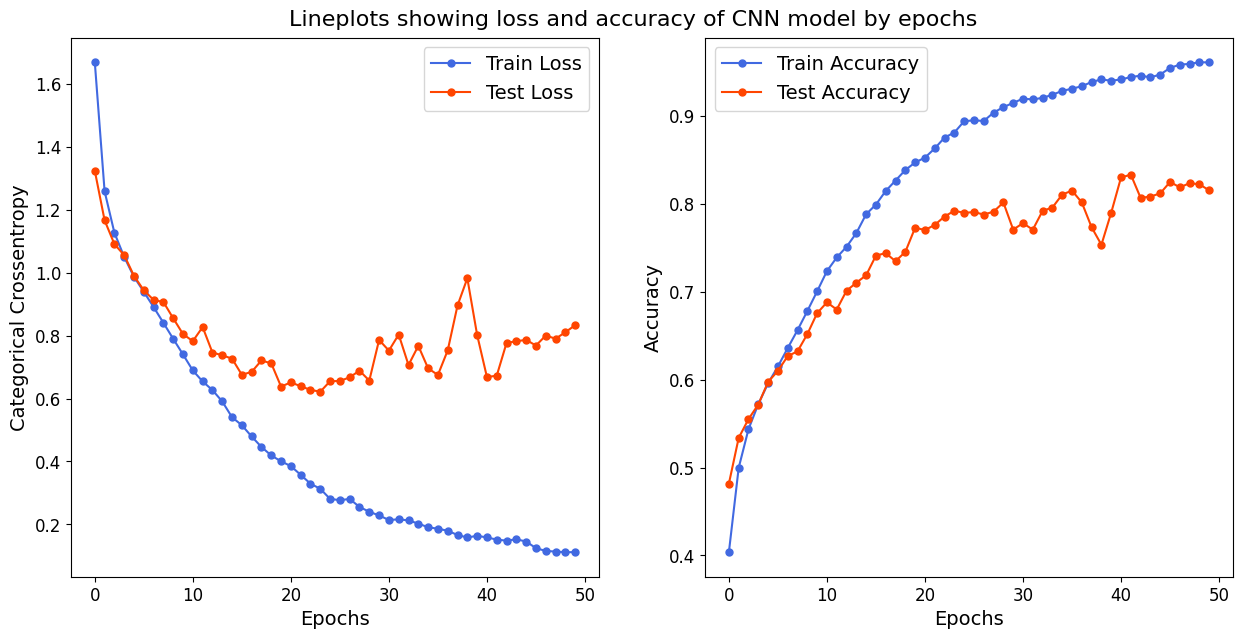

In [40]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

In [41]:
# Evaluating the model on test dataset.

final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

93/93 [==============================] - 1s 7ms/step - loss: 0.8334 - accuracy: 0.8150


In [42]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.833
CNN model accuracy 	= 0.815


**Saving the model**

In [43]:
# Saving the model as a h5 file for possible use later.

final_cnn.save(f'/output/age_model_acc_{round(final_cnn_score[1], 3)}.h5', save_format='h5')